<img src="https://images.unsplash.com/photo-1460672985063-6764ac8b9c74?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=1355&q=80" width="500">
Photo by <a href="https://unsplash.com/@jessedo81?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">jesse orrico</a> on <a href="https://unsplash.com/s/photos/heart?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

# Heart Attack Prediction - UCI Dataset


## <center style="background-color:Gainsboro; width:40%;">Contents</center>
1. [Overview](#1.-Overview)<br>
    1.1 [The Attributes](#1.1.-The-Attributes)<br>
    1.2 [Acknowledgements](#1.2.-Acknowledgements)<br>
2. [The Data](#2.-The-Model)<br>
    2.1 [Target Feature Analysis](#2.1.-Target-Feature-Analysis)<br>
    2.2 [Age and Gender](#2.2.-Age-and-Gender)<br>
    2.3 [New Features](#2.2.-New-Features)<br>
3. [Model](#3.-Model)<br>   
4. [Results and Conclusion](#4.-Results-and-Conclusion)<br>

***Please remember to upvote if you find this Notebook helpful!***

# Key Remarks:

* Overall, the dataset is balanced between both classes of the Target feature. However, there is an expressive unbalance regarding gender, where Males compose ~70% of the data
* The Female samples are mostly from positive Heart Attacks
* The median age for Males with No Heart Attacks is higher than for Males that had Heart Attacks
* A higher concentration of positive Heart Attack samples appears in the region where lower values for Age and Cholesterol and higher values of Heart rate meet
* Data Scaling, OneHotEncoding and the use of KMean for the creation of new features did not improve model generalisation
* In the training set results, the model shows a tendency for FP
* Best Model is Logistic Regression with 89,7% Accuracy. The models were finely tuned with Optuna Library

# 1. Overview

The diagnosis of heart disease is done on a combination of clinical signs and test results. The importance of a correct early diagnosis is primordial to provide care and avoid casualties. Examples of types of tests to understand if a patient is suffering or at risk of a heart attack are: electrocardiograms, cardiac computerized tomography (CT) scans, blood tests and exercise stress tests. Also, the literature cites risk factors for heart attacks as high cholesterol, high blood pressure, diabetes, weight, family history and smoking. Age, gender and genetic predisposition also play a role. 

The Heart Attack UCI database originally contained 76 attributes and was created to detect the presence of heart disease in patients using ML algorithms. In the original database, the target features are integers valued from 0 (no presence) to 4. However, most experiments refer to using this dataset instead, containing only fourteen of the original attributes. Experiments with the UCI database have also concentrated on simply attempting to distinguish presence (values 1,2,3,4 as 1) from absence (value 0) of heart disease. In this notebook we follow the same approach, analysing the data as a binary classification problem.

# 1.1 The Attributes

* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type  (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot)
* slope - the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
* ca - number of major vessels (0-3) colored by flourosopy
* thal - a blood disorder called thalassemia
* target - have disease or not (1=yes, 0=no)

# 1.2 Acknowledgements

According to the UCI Machine Learning Repository, the dataset creators are:

1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

>Libraries

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import os
#Model
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#Optimisation
import pickle
import optuna

>Functions

In [2]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

def percentPlot(heart_df,categorical_class,title,hue):
    j = 0
    for i in categorical_class:    

        plt.figure(figsize=(20,5))
        ax = sns.countplot(x=i, data=heart_df,palette="Blues_d", hue = hue)

        for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_height()/total)
                x = p.get_x() + p.get_width()/2
                y = p.get_y() + p.get_height() + 0.02
                ax.annotate(percentage, (x, y),
                            ha='center', va='bottom', 
                            color='black', xytext=(0, 3),
                            rotation = 'horizontal',
                            textcoords='offset points')

        sns.despine(top=True, right=True, left=True, bottom=False)
        plt.xticks(rotation=0,fontsize = 12)
        ax.set_xlabel(title[j],fontsize = 14)
        ax.set(yticklabels=[])
        ax.axes.get_yaxis().set_visible(False)
        plt.title('Distribution of '+title[j],fontsize = 14,weight = 'bold')
        j+=1
        plt.show()
    

# 2. The Data

First, we review the basic information of the dataset, i.e. number of features, samples, missing values and the necessity of any Data Cleansing. Next, bar plots are used to have a broad understanding of the categorical features. 

In the following sections, we have a deeper look at the Target feature and its relationship with the remaining features. Scatter and Density plots are used to visualise patterns with numerical data. 

In [3]:
heart_df = pd.read_csv('../input/heart-disease-uci/heart.csv')

In [4]:
basic_EDA(heart_df)

Number of Samples: 303,
Number of Features: 14,
Duplicated Entries: 1,
Null Entries: 0,
Number of Rows with Null Entries: 0 0.0%


In [5]:
summary_table(heart_df)

,Name,dtypes,Missing,Uniques
0,age,int64,0,41
1,sex,int64,0,2
2,cp,int64,0,4
3,trestbps,int64,0,49
4,chol,int64,0,152
5,fbs,int64,0,2
6,restecg,int64,0,3
7,thalach,int64,0,91
8,exang,int64,0,2
9,oldpeak,float64,0,40


The above outputs show that no Data Cleansing is required, only a duplicated entry needs to be deleted. We also identify the numerical from the categorical features by looking at the Summary table. 

Even though they are simple, the bar plots provide a good insight regarding the model categorical features:

In [6]:
#Remove Duplicates
heart_df.drop_duplicates(inplace = True)

In [7]:
#Dictionaries to make the understanding of the data easier
gender_dict = {
    0: 'Female',
    1: 'Male'}
cp_dict = {
    0:'Typical Angina',
    1:'Atypical Angina',
    2:'Non-anginal Pain',
    3:'Asymptomatic'}
slope_dict = {
    0: 'Upsloping',
    1:'Flat',
    2:'Downsloping'}
restecg_dict = {
    0: 'Normal',
    1: 'Wave Abnormality',
    2: 'Left Ventr. Hypertrophy'}
bin_dict = {
    0:'No',
    1:'Yes'
}


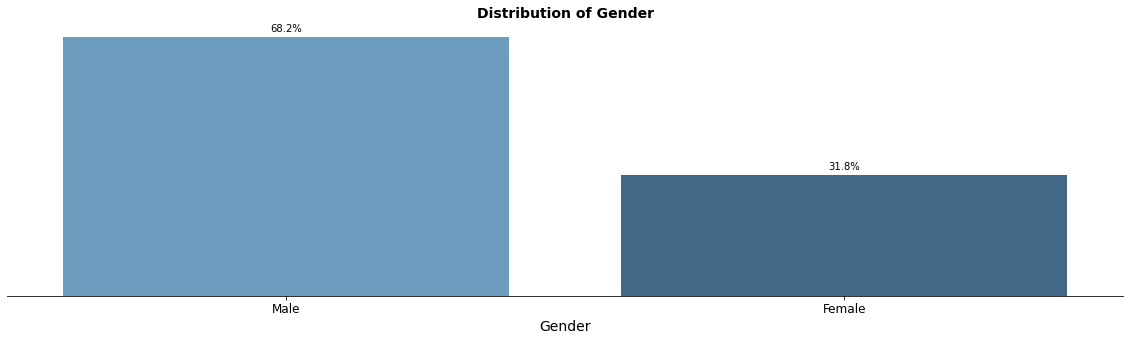

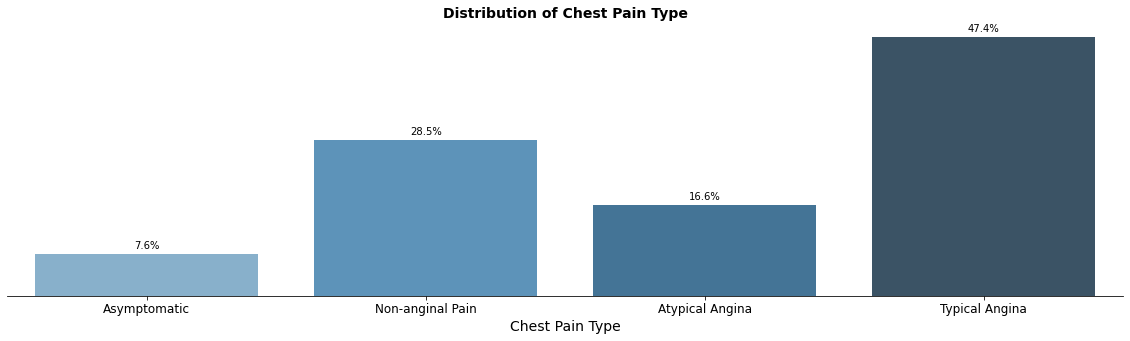

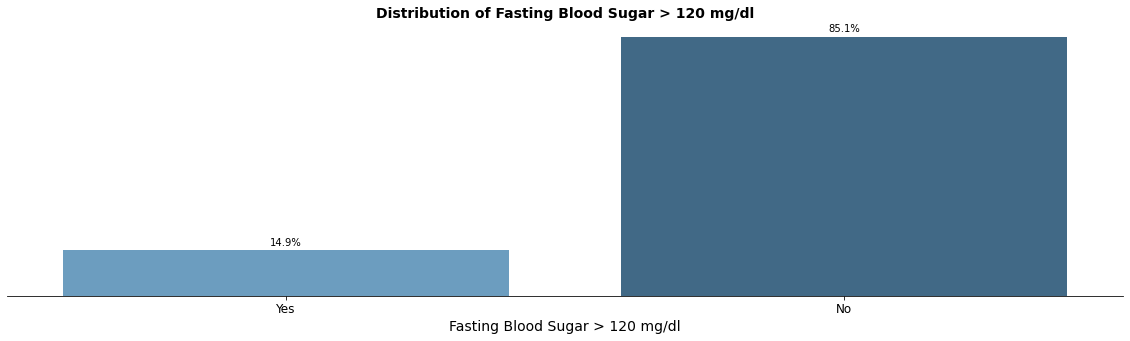

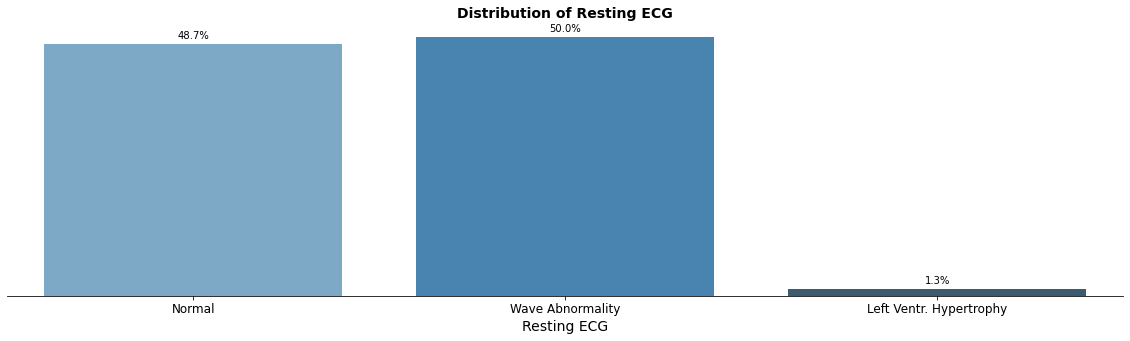

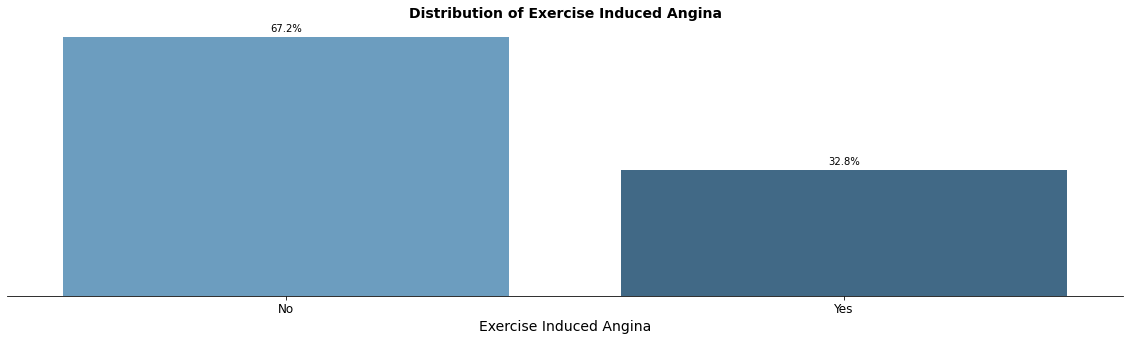

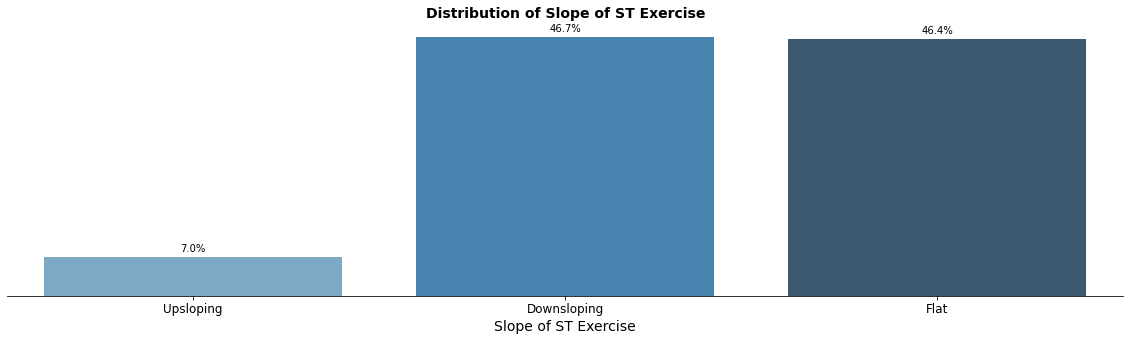

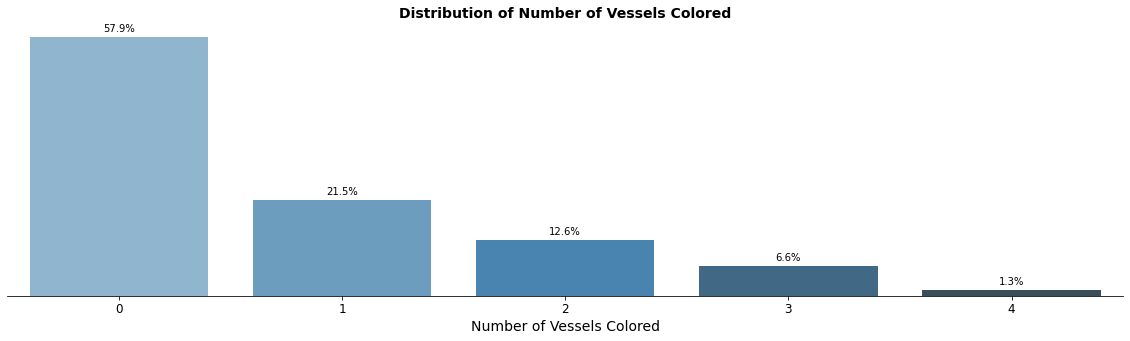

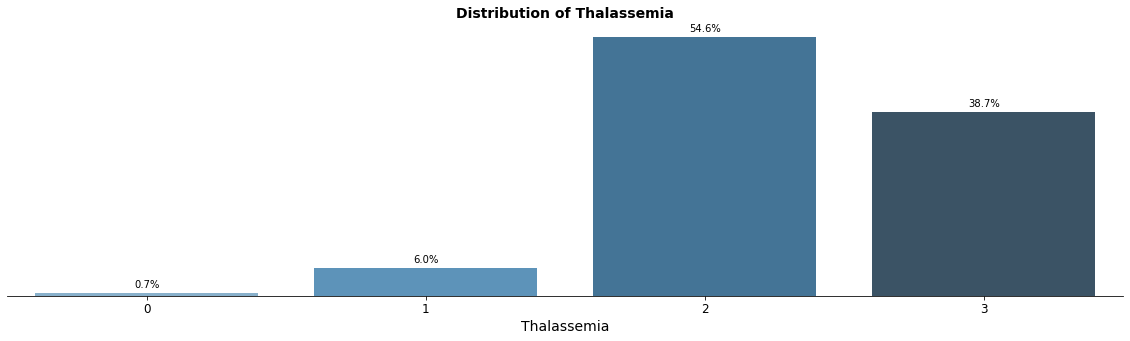

In [8]:
categorical_feat = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
cat_title = ['Gender','Chest Pain Type','Fasting Blood Sugar > 120 mg/dl',
         'Resting ECG','Exercise Induced Angina','Slope of ST Exercise',
         'Number of Vessels Colored','Thalassemia' ]

numerical_feat = ['age','trestbps','chol','thalach','oldpeak']
num_title = ['Age', 'Resting Blood Pressure','Cholesterol','Max. Heart Rate', 'ST Depression Induced by Exercise']

heart_df['sex'] = heart_df['sex'].map(gender_dict.get)
heart_df['cp'] = heart_df['cp'].map(cp_dict.get)
heart_df['slope'] = heart_df['slope'].map(slope_dict.get)
heart_df['restecg'] = heart_df['restecg'].map(restecg_dict.get)
heart_df['fbs'] = heart_df['fbs'].map(bin_dict.get)
heart_df['exang'] = heart_df['exang'].map(bin_dict.get)
heart_df['target'] = heart_df['target'].map(bin_dict.get)

total = len(heart_df['target'])

percentPlot(heart_df,categorical_feat,cat_title,None)

* The dataset contains a small number of samples and displays a high unbalance regarding some features
* Almost 70% of samples are from male patients, such data could be dangerously biased toward this important feature
* Most samples are from patients with lower fasting blood sugar (85%)
* Other features that present a high gap  between the different feature categories are: 
    * Resting ECG - where only 1% are from type 2 (left ventricular hypertrophy). The remaining options are equally distributed
    * Slope ST Exercise - samples are equally distributed between flat (1) and downsloping (2), with only 7% showing an upslope after the exercise
    * Vessels Coloured - Majority of samples (~60%) from patients where none of the vessels was coloured in the fluoroscopy test

# 2.1 Target Feature Analysis

After the initial analysis, let's visualise how each feature relates to the target. 

It is important to keep in mind that some features, such as gender or blood sugar, have a majority of samples from one class. As such, there will be an impression that specific situations seem more favourable to a heart attack simply because there is a high number of samples. 

With that in mind, the bar plots below will serve to easily visualise the categories within the features that contain more samples from target 0 or 1, e.g. the discrepancy between the number of samples for positive and negative heart attacks of female subjects

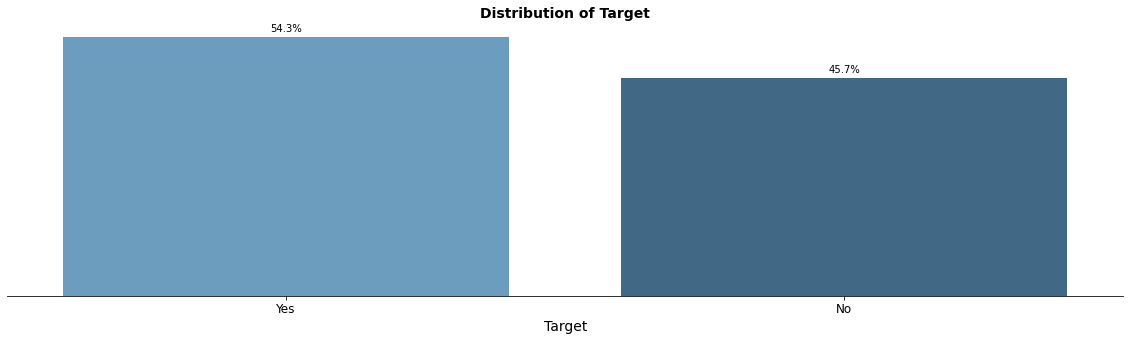

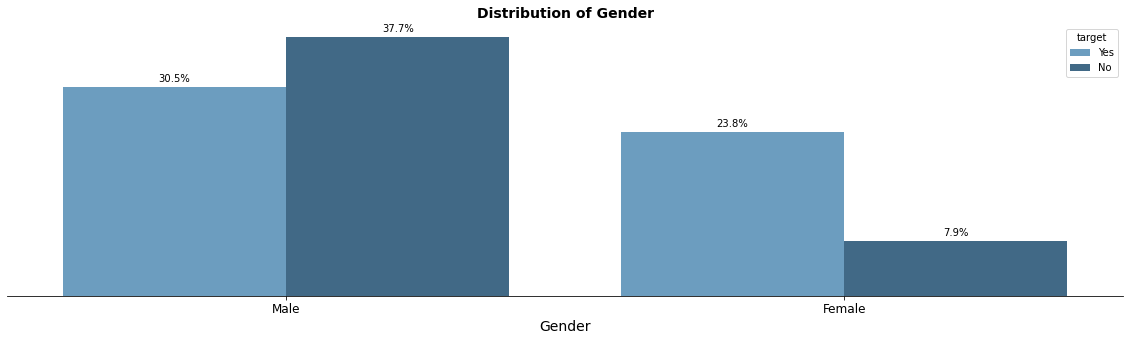

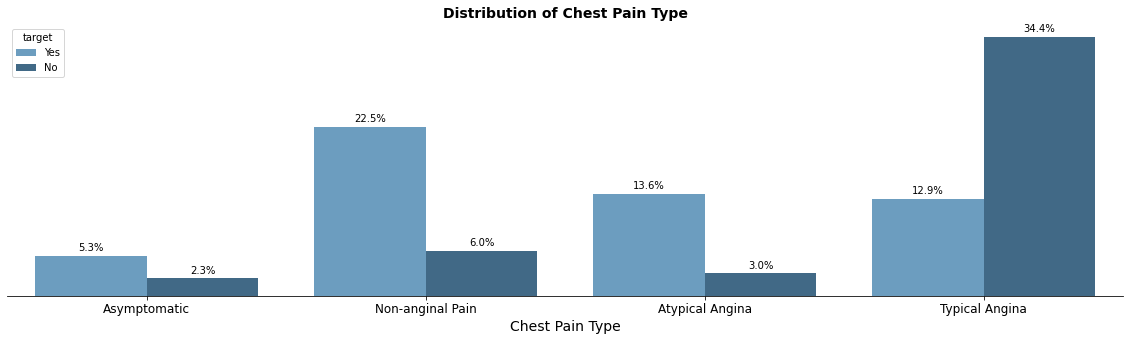

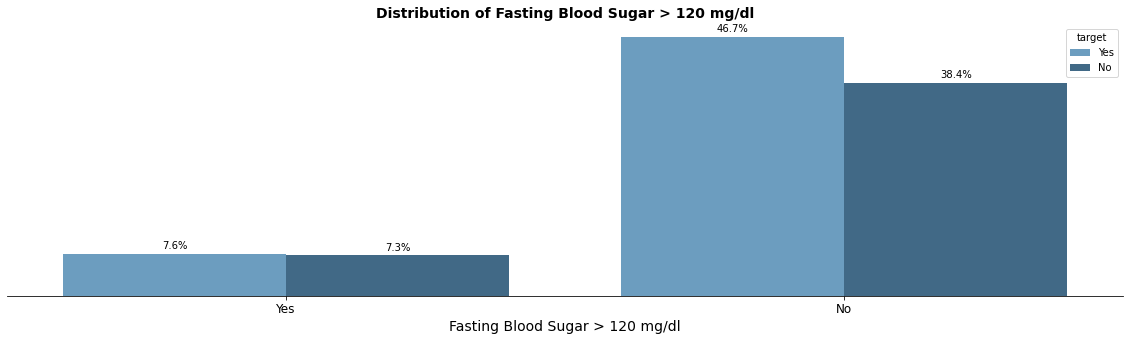

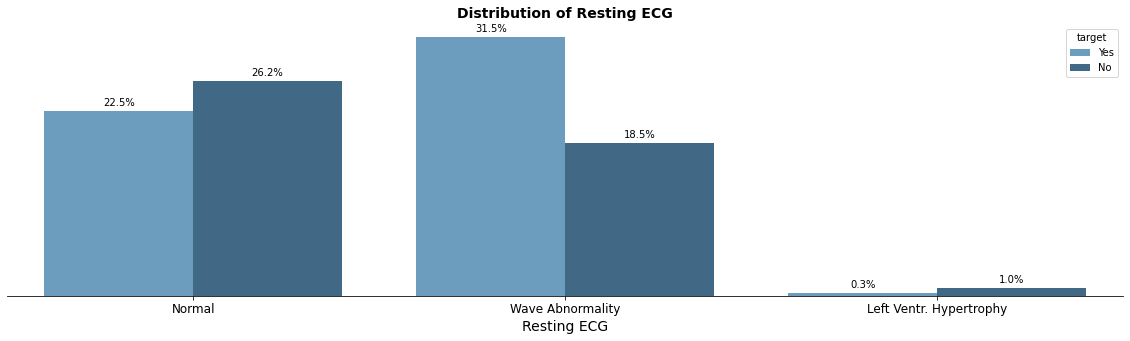

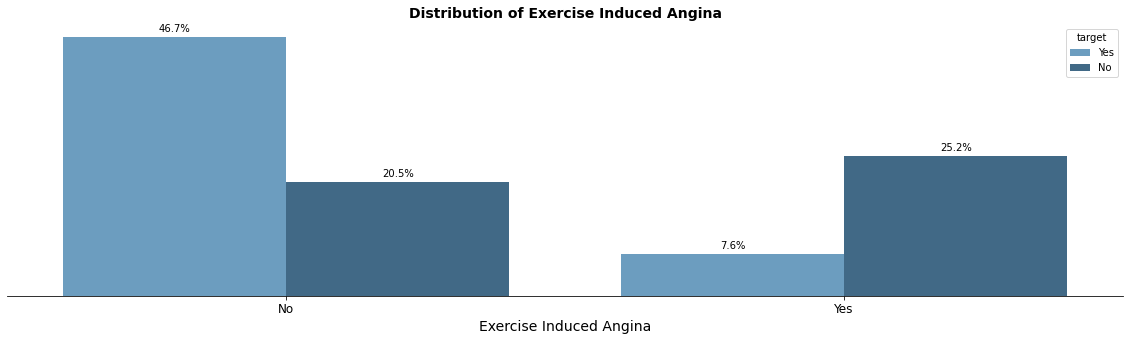

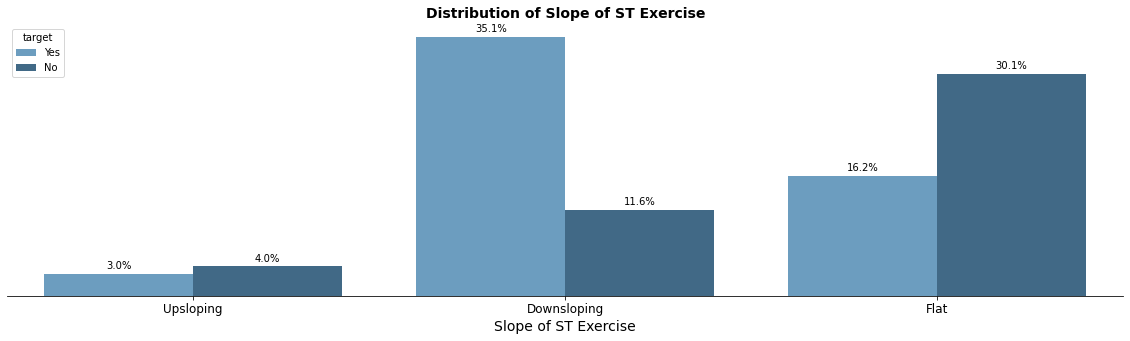

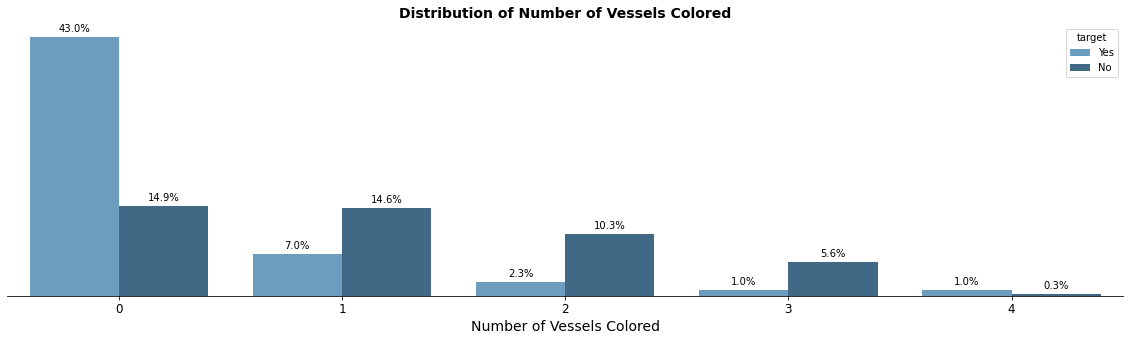

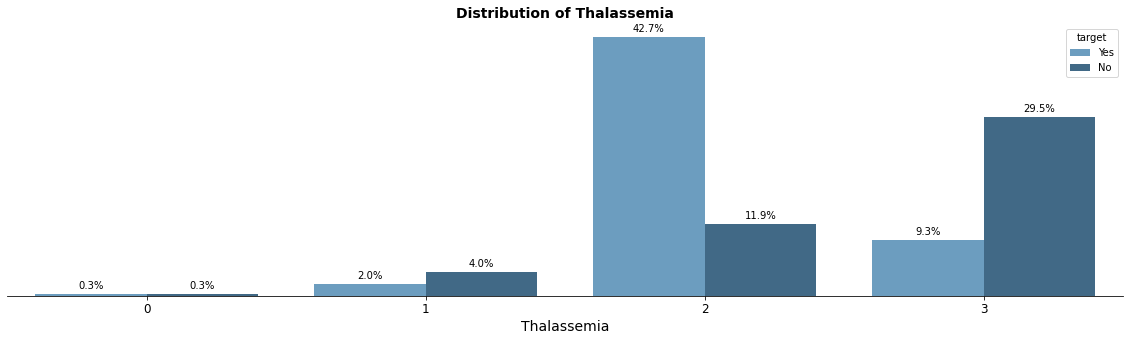

In [9]:
percentPlot(heart_df,['target'],['Target'],None)
percentPlot(heart_df,categorical_feat,cat_title,'target')

* The dataset contains a similar number of samples for both target categories, Yes = 1 and No = 0 Heart attack
* Most of the Female samples (0) are from a positive heart attack condition. It could be a dataset bias or females have more predisposal for this condition. For males there is a similar number of samples for both conditions
* Regarding chest pain, while most samples are from "Typical Angina",  only a quarter of these are from positive heart attacks. Patients presenting Non-anginal pain (2) seem to have a higher predisposal to present a heart attacks
* Patients with higher blood sugar show a similar percentage for both targets. Patients with blood sugar lower than 120 mg/dl present a higher percentage of class 1 samples. However, 80% of all data are from patients with lower blood sugar
* Regarding the ECG test, ST-T wave abnormality (1) represents 31.5% of samples of heart attack patients 
* The number of vessels coloured by fluoroscopy also seems to be a relevant parameter. When none of the vessels is coloured there is a big difference in the distribution between both targets. 

Now let's analyse the relationship between the target and numerical data.

<Figure size 1440x576 with 0 Axes>

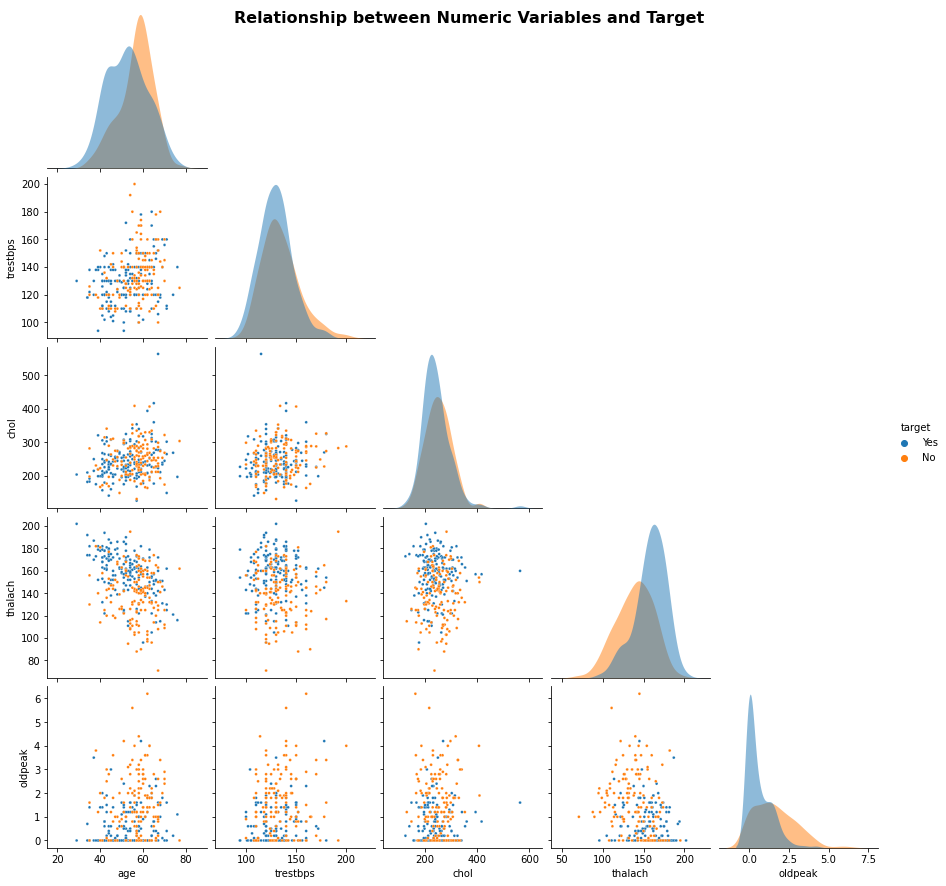

In [10]:
plt.figure(figsize=(20,8));
g = sns.pairplot(heart_df,vars=['age','trestbps','chol','thalach','oldpeak'],hue = 'target',corner=True,
                 plot_kws=dict(s = 8),
                 diag_kws=dict(linewidth=0,alpha=.5));
g.fig.suptitle('Relationship between Numeric Variables and Target',fontsize=16, weight = 'bold');

* Age, oldpeak (ST Depression Induced by Exercise), and Heart Rate (thalach) are the features where both targets are visually separable
* The KDE plot for Blood Pressure (trestbps) and Cholesterol (chol) are quite similar for both targets. As such, the scatter plots for these two features are not separable by class
* Considering the Age Feature:
    * The KDE plot shows for class 1 a mean around the age of 50, with a secondary peak at the age of 40. For class 0, there is a narrower KDE curve, meaning more samples are closer to their mean value. The blue right-tail curve presents a mean slightly higher than class 1, ~ 55-60 years
    * Regarding cholesterol (chol) and Heart Rate (thalach), from the ages 35 to 50 it appears to be a majority of class 1 (heart attack samples). Following what the KDE plot demonstrated
    * The samples seem to be distributed according to the oldpeak (ST Depression Induced by Exercise) value, not the age as much. Orange (class 1) samples are more evident for the values of 0, 1 and 2 for oldepeak
* Considering the thalac (Heart Rate) Feature:
    * The KDE plot shows a distinct distribution for the target samples. Class 1 samples present a higher mean than class 0 samples
    * The higher mean pattern is visible across the scatter pair plots for this feature. Note how most of the orange samples (class 1) are usually concentrated for higher values of thalach
    


From the scatter plots, it was possible to notice that age, thalach and chol were important features as they provided nice target separations. Could we extract any additional insight using a 3D plot from these three features?

In [11]:
fig = px.scatter_3d(heart_df, x="chol", y="thalach", z="age",color='target',opacity=0.9)
fig.update_traces(marker=dict(size=5))#, selector=dict(type='scatter3d'))
fig.update_layout(title=dict(text = 'Age, Cholesterol and Heart Rate 3D plot'))
fig.show()

* It is possible to visualise a higher concentration of target = 1 samples in the region where lower values for Age and Cholesterol and high values of Heart rate meet
* Perhaps a new feature that takes into account these three indicators could be helpful to the model

# 2.2 Age, Gender and Heart Attacks

Next, let's analyse any trends between gender, age and the possibility of heart attack. The plot below shows the age of all samples that belong to class 1 (Heart Attack), segmented by gender.

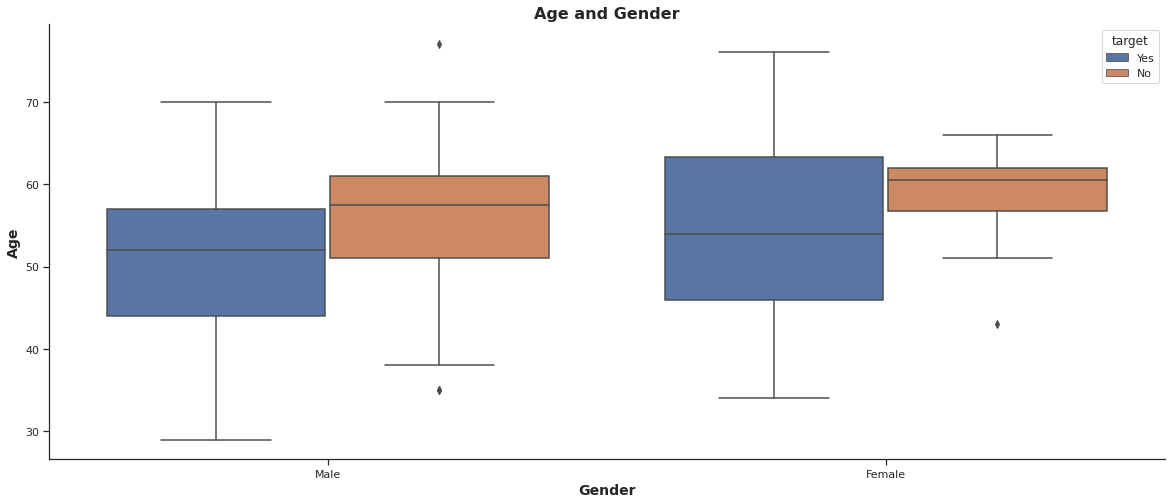

In [12]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.boxplot(x="sex", y="age", data=heart_df, hue = 'target')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Gender',fontsize = 14,weight = 'bold')
ax.set_ylabel('Age',fontsize = 14,weight = 'bold')
plt.title('Age and Gender', fontsize = 16,weight = 'bold');

* The mean Age is higher for Females considering both Targets, Yes and No Heart Attack
* The mean age for Males with No Heart Attacks is higher than samples with Heart Attacks, which is unexpected
* The Interquantile Range for No Heart Attacks targets presents a smaller variability if compared to the Yes class. This is valid for both genders
* For positive Heart Attack samples, the median for Male and Females are similar. For Negative samples, Females have a higher median than Males

Using a bar plot, we can visualise the Age and Gender samples in more detail.

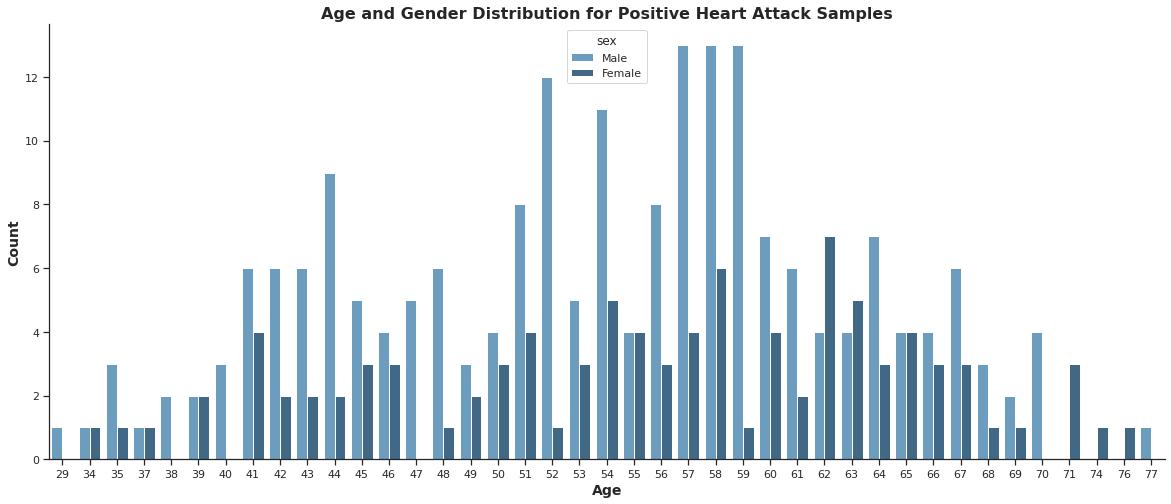

In [13]:
heartTarget = heart_df[heart_df['target']==1]
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = heart_df,x='age',palette="Blues_d", hue = 'sex')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Age',fontsize = 14,weight = 'bold')
ax.set_ylabel('Count',fontsize = 14,weight = 'bold')
plt.title('Age and Gender Distribution for Positive Heart Attack Samples', fontsize = 16,weight = 'bold');

* For male samples, there are clear peaks at age 44, 52 and 57-59 years. For females, the peaks are 54, 58, 62 and 63 year old
* 62 and 63 age groups are the only ages where females had more heart attack than males. It is surprising due to the small number of female samples
* While the distribution of age differ between both genders, most samples of positive heart attack are from patients from the age of 50 and beyond
* The number of heart attack for males almost doubles from 40 to 41 years of age



## 2.3 New Features

In the previous section we saw the Heart Rate, Cholesterol and Age were features that presented a good separation between the targets. More importantly, the scatter plots where features were plotted against the Heart Rate (thalach) presented a better sample separation. The code below creates new features by dividing one by the other:
* age_chol: ratio of the Age and Cholesterol level of the sample
* chol_thalach: ratio of the Heart Rate and Cholesterol level of the sample
* thalach_trestbps: ratio of the Heart Rate and Blood Pressure level of the sample
* age_thalach: ratio of the Age and Heart Rate of the sample

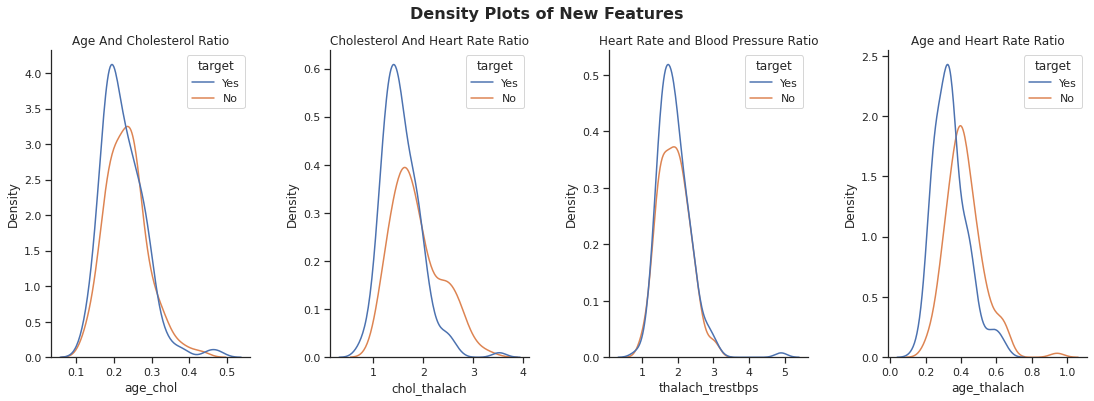

In [14]:
heart_df['age_chol'] = heart_df['age'].div(heart_df['chol'])
heart_df['chol_thalach'] = heart_df['chol'].div(heart_df['thalach'])
heart_df['thalach_trestbps'] = heart_df['chol'].div(heart_df['trestbps'])
heart_df['age_thalach'] = heart_df['age'].div(heart_df['thalach'])

fig, axarr = plt.subplots(1,4, figsize=(16, 6))

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

dfs = ['age_chol','chol_thalach','thalach_trestbps','age_thalach']
z = 0
for j in range(0,4):
    ax = sns.kdeplot(data = heart_df, x = dfs[z], hue = 'target',ax=axarr[j]);
    z +=1
        
axarr[0].set_title("Age And Cholesterol Ratio")
axarr[1].set_title("Cholesterol And Heart Rate Ratio")
axarr[2].set_title("Heart Rate and Blood Pressure Ratio")
axarr[3].set_title("Age and Heart Rate Ratio")

fig.tight_layout(pad=3.0)
plt.suptitle('Density Plots of New Features',fontsize=16, weight = 'bold');
      
plt.show()

* The features that were able to distinct the most between the classes are the ones that combined Age and Cholesterol to Heart rate (second and fourth plots)
* The first and third plots present quite similiar distribution between classes, as such is not clear if it will be helpful to the ML model

### K-Means Clustering

The section below performs a quick analysis using KMeans to cluster the data. The objective is to understand if KMeans clusters can help us visualise any other patterns we may have missed.  Later on, such insights could help us create new features for the ML model.

<Figure size 1440x576 with 0 Axes>

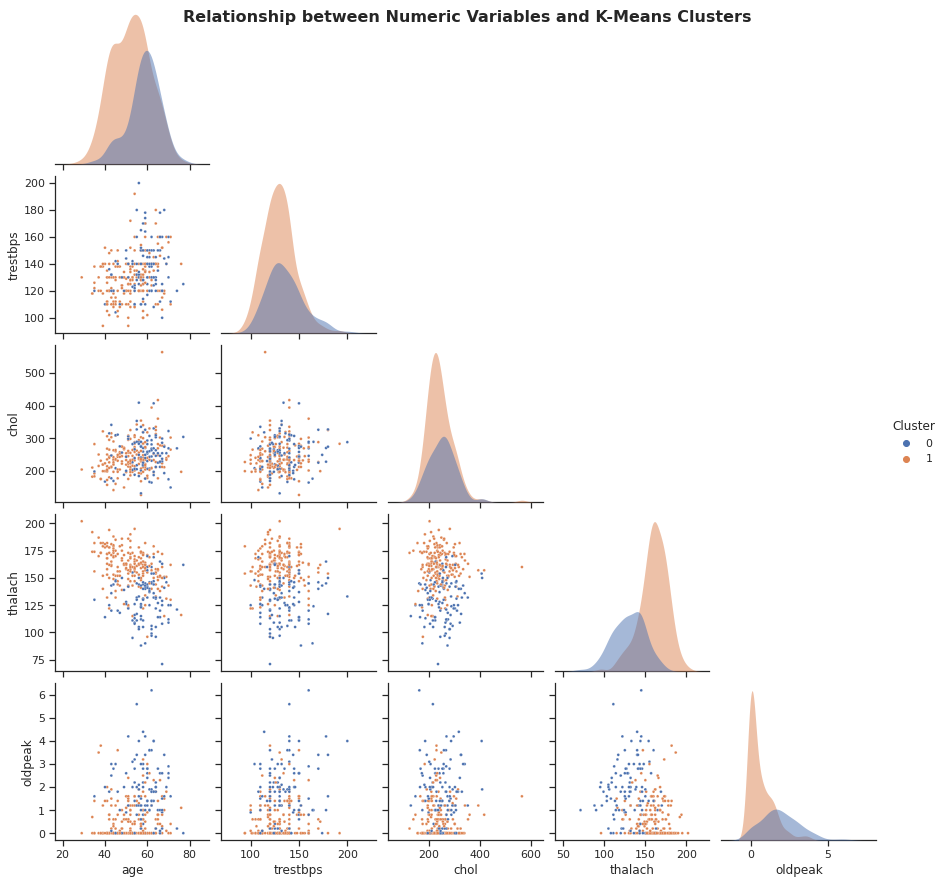

In [15]:
df = pd.read_csv('../input/heart-disease-uci/heart.csv')
KmeanData = df.copy()
scaler = preprocessing.StandardScaler()
KmeanData = scaler.fit_transform(KmeanData.iloc[:,:-1])
kmeans = KMeans(n_clusters=2)

df["Cluster"] = kmeans.fit_predict(KmeanData)

plt.figure(figsize=(20,8));
g = sns.pairplot(df,vars=['age','trestbps','chol','thalach','oldpeak'],hue = 'Cluster',corner=True,
                 plot_kws=dict(s = 8),
                 diag_kws=dict(linewidth=0,alpha=.5));
g.fig.suptitle('Relationship between Numeric Variables and K-Means Clusters',fontsize=16, weight = 'bold');

* It is interesting that the KMeans algorithm has separated the samples in a similar manner, even though it was fitted without the Target column
* This method could be used as an additional feature for the final model. However, it should be fitted only to the training set, not the whole dataset as we did to create the above visualisation 

# 3. Model

The dataset is rather small, it is necessary to be careful regarding Overfitting. From experience, it would not be advisable to use models that are prone to overfitting, such as ANN. For this reason, we will explore other Machine Learning Models.

### Preliminary Results
* Random Forest (RF), Logistic Regression (LR), SVM and KNN models were considered at first: 
    * KNN had the worse performance and was excluded from the optimisation step
    * SVM was also excluded as it presented similar outcomes as LR and Random Forest. However, optimising its parameters takes more time and it is more prone to overfitting than RF.
    * A smaller search space with parameters for Random Forest and LR is more effective than trying to optimise several models and parameters at once
* Scaling the features reduces the model accuracy
* Encoding the categorical variables to binary values did not improve the model performance
* The new features did not improve model performance and were commented out of the code

### Basic Approach:
* Use Optuna to find the more promising model 
* Find the best model and use Optuna once more for final hyperparameter tuning
* Five Cross-Validation and a separate test set are used
* Analyse results using Confusion Matrix
* Check if ML probability cutoff is appropriate

>Data Preparation

In [16]:
np.random.seed(42)
df = pd.read_csv('../input/heart-disease-uci/heart.csv')
target = df.iloc[:,-1]

feature = df.drop(columns=['target'])
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2)

>Optuna Code

In [17]:
optuna.logging.set_verbosity(optuna.logging.WARNING) #Disable Warnings

def create_model(trial):
    model_type = trial.suggest_categorical('model_type', ['random-forest', 'logistic-regression'])
        
    if model_type == 'logistic-regression':
        regularization = trial.suggest_uniform('logistic-regularization', 0.01, 20)
        model = LogisticRegression( C=regularization, solver='liblinear')
    
    if model_type == 'random-forest':
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 500)
        rf_max_depth = trial.suggest_int("rf_max_depth", 1, 50)
        rf_min_samples = trial.suggest_int("rf_min_samples", 1, 50)
        rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 50)
        rf_ccp_alpha = trial.suggest_float("rf_ccp_alpha", 0, 1)

        model = RandomForestClassifier(max_depth=rf_max_depth, 
                                        n_estimators=rf_n_estimators,
                                        min_samples_split = rf_min_samples,
                                        min_samples_leaf = rf_min_samples_leaf,
                                        ccp_alpha = rf_ccp_alpha)
        
    if trial.should_prune():
            raise optuna.TrialPruned()
            
    return model


def objective(trial):
    model = create_model(trial)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5,scoring='f1')
    accuracy = score.mean()
    # Save a trained model to a file.
    with open("{}.pickle".format(trial.number), "wb") as fout:
        pickle.dump(model, fout)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)
print(f"The best parameters are : \n{study.best_params}")
print("Mean F1-Score of Cross-Validation Sets: %.4f"% (study.best_value))

[W 2021-04-06 20:49:15,648] Trial 384 failed, because the objective function returned nan.


The best parameters are : 
{'model_type': 'random-forest', 'rf_n_estimators': 167, 'rf_max_depth': 27, 'rf_min_samples': 10, 'rf_min_samples_leaf': 41, 'rf_ccp_alpha': 0.03399263131519998}
Mean F1-Score of Cross-Validation Sets: 0.8578


From the models chosen to be run with the Optuna library, Logistic Regression is the one which presented better results. 

# Results and Conclusion

The Optuna Library has optimised the hyperparameters of the four models and chose the best one. Since the previous optimisation had a large search space and it does not take much time to run the optimisation again, here we run the same code with the intent to get any improvements focusing on a smaller set of parameters. The best results are selected according to the Cross-Validation F1 metric.

For this particular application, there is not an expressive need to use the F-Score in place of Accuracy as the classes are balanced. However, since it is a serious disease, it is good to use more than one metric to evaluate how the TP and TN are being handled. Preliminary experimentations have shown that the Accuracy and F1-Score are providing similar results (both metrics near 80%).

>Optuna Code for LR

In [18]:
optuna.logging.set_verbosity(optuna.logging.WARNING) #Disable Warnings

def create_model(trial):
    regularization = trial.suggest_uniform('logistic-regularization', 0.0001, 1)
    lr_intercept_scaling = trial.suggest_uniform('lr_intercept_scaling', 0.0001, 1)
    model = LogisticRegression( C=regularization, solver='liblinear',intercept_scaling = lr_intercept_scaling)
    
    if trial.should_prune():
            raise optuna.TrialPruned()
            
    return model

def objective(trial):
    model = create_model(trial)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5,scoring='f1')
    accuracy = score.mean()
    # Save a trained model to a file.
    with open("{}.pickle".format(trial.number), "wb") as fout:
        pickle.dump(model, fout)
    return accuracy

study = optuna.create_study(direction="maximize");
study.optimize(objective, n_trials=500);
print("Mean F1-Score of Cross-Validation Sets: %.4f"% (study.best_value))
print("The best parameters are: ", (study.best_params))

Mean F1-Score of Cross-Validation Sets: 0.8571
The best parameters are:  {'logistic-regularization': 0.19874039242738092, 'lr_intercept_scaling': 0.30291692466092224}


In [19]:
with open("{}.pickle".format(study.best_trial.number), "rb") as fin:
    best_clf = pickle.load(fin)
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
print("Accuracy of Test Set: %.4f"% (accuracy_score(y_test, y_pred)))
print("F1-Score of Test Set: %.4f"% (f1_score(y_test, y_pred)))

Accuracy of Test Set: 0.8852
F1-Score of Test Set: 0.8923


Finally, let's analyse the Confusion Matrix and see how our model perfomance in greater detail:

>Confusion Matrix

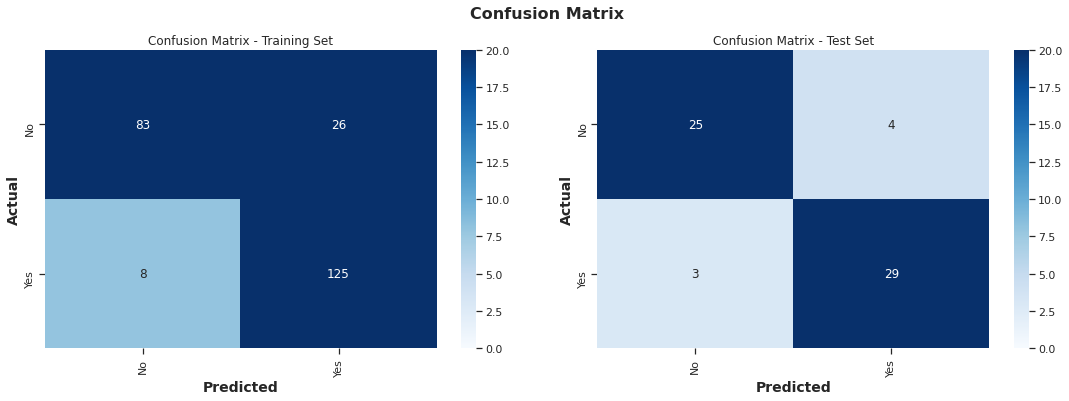

In [20]:
categories = ['No','Yes']

CMatrix_test = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=categories, index =categories)
CMatrix_train = pd.DataFrame(confusion_matrix(y_train, best_clf.predict(X_train)), columns=categories, index =categories)

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

dfs = [CMatrix_train,CMatrix_test]
z = 0
for j in range(0,2):
    ax = sns.heatmap(dfs[z], annot = True, fmt = 'g' ,vmin = 0, vmax = 20,cmap = 'Blues',ax=axarr[j])

    axarr[j].set_xlabel('Predicted',fontsize = 14,weight = 'bold')
    axarr[j].set_xticklabels(ax.get_xticklabels(),rotation =90)
    axarr[j].set_ylabel('Actual',fontsize = 14,weight = 'bold')    

    z +=1
        
axarr[0].set_title("Confusion Matrix - Training Set");
axarr[1].set_title("Confusion Matrix - Test Set");

fig.tight_layout(pad=3.0)
plt.suptitle('Confusion Matrix',fontsize=16, weight = 'bold');
      
plt.show()

* In the training set, the number of samples misclassified as Yes is expressive if compared to the number of samples misclassified as No. The same trend is not visible in the Test set
* In a way, it is best that the model present a False Positive tendency than the contrary for this application

It is possible to visualise how our model is predicting the probability of each samples by using KDE plots. By looking at this distribution one can conclude if raising the class probability cuttof from 0,5 to a higher value we can adjust the model tendency to FP.

>Class Probability Plot

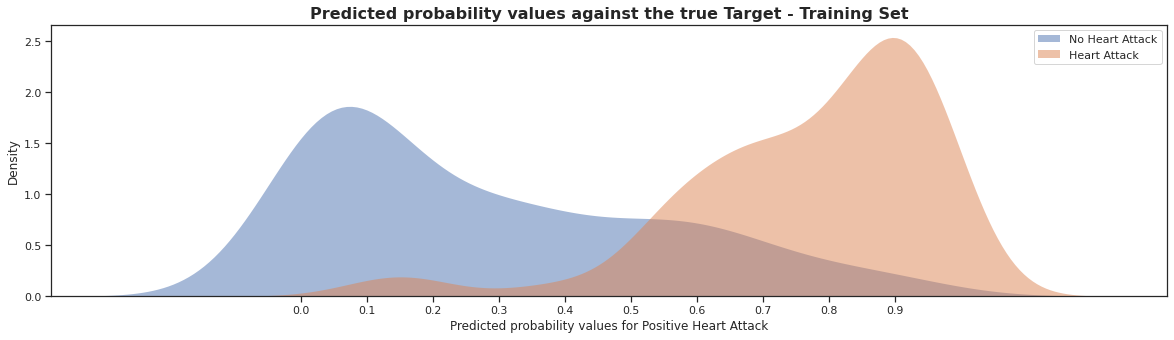

In [21]:
def probability_class(y_proba, true_label):
    plt.figure(figsize=(20,5))
    ax = sns.kdeplot(y_proba[true_label==0], label="No Heart Attack",linewidth=0,alpha=.5, fill = True)    
    ax = sns.kdeplot(y_proba[true_label==1], label="Heart Attack",linewidth=0,alpha=.5,fill = True)
    plt.xticks(np.arange(0,1, 0.1))
    plt.xlabel("Predicted probability values for Positive Heart Attack")
    plt.ylabel("Density")
    plt.title("Predicted probability values against the true Target - Training Set",fontsize=16, weight = 'bold'); 
    plt.legend();
    
probability_class(best_clf.predict_proba(X_train)[:,1],y_train)

From the plot above we understand where the False Positives are coming from. Looking at the No Heart Attack samples, there is a significant number of them with a probability higher than 0,5. In contrast, Class 1 samples behave as expected, having a sharp descent as it gets closer to 0,5.

It is a valid strategy to change the cutoff to a higher value to increase the accuracy. However, both classes are already nicely separated and it is preferrable to use such manouvers as a last resort.

## Future Work

For this application, Logistic Regression achieved almost 90% accuracy. As additional ideas to improve model performance:
* Ensemble of different models
* More effort on creating new features
* Perform a deeper analysis to understand what kind of samples are being misclassified. From this study, generate synthetic samples with such characteristics to improve model generalisation